In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt




In [5]:
# ---------------- LOAD DATA ----------------
orders=pd.read_csv("scm_order_lines.csv",parse_dates=["order_date","ship_date","promised_delivery_date"])
inv=pd.read_csv("scm_inventory_positions.csv",parse_dates=["date","next_po_eta"])
forecast=pd.read_csv("scm_forecast.csv",parse_dates=["date"])

In [6]:
# ---------------- KPI ----------------
orders["fill_rate"]=orders["delivered_qty"]/orders["ordered_qty"]
orders["fill_rate"]=orders["fill_rate"].clip(upper=1)
sku_fill=orders.groupby("sku")["fill_rate"].mean().sort_values(ascending=False)
overall_fill=orders["fill_rate"].mean()

sku_fill.head()
overall_fill

np.float64(0.292)

In [7]:
# ---------------- KPI Section ----------------
orders["in_full"] = orders["delivered_qty"] >= orders["ordered_qty"]
orders["on_time"] = orders["ship_date"] <= orders["promised_delivery_date"]
orders["otif"] = orders["in_full"] & orders["on_time"]

carrier_otif = orders.groupby("carrier")["otif"].mean().sort_values(ascending=False)
carrier_otif


carrier
Delhivery      0.829787
BlueDart       0.760000
XpressBees     0.641026
EcomExpress    0.620690
Name: otif, dtype: float64

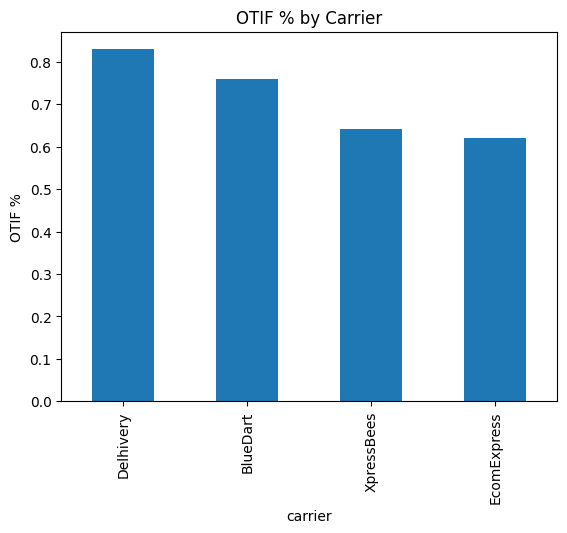

In [8]:
# ---------------- OTIF by Carrier ----------------
carrier_otif.plot(kind="bar")
plt.title("OTIF % by Carrier")
plt.ylabel("OTIF %")
plt.show()


In [9]:
forecast["forecast_demand"] = forecast["forecast_demand"].replace(0, np.nan)
forecast["forecast_demand"] = forecast["forecast_demand"].fillna(1)


In [10]:
# ---------------- Forecast demand Table ----------------
dos = inv.merge(forecast, on=["date","sku"], how="left")
dos["dos"] = dos["on_hand"] / dos["forecast_demand"]
dos.head()


,date,sku,warehouse,on_hand,safety_stock,next_po_eta,forecast_demand,dos
0,2025-03-01,P001,BLR_WH,26,6,2025-03-06,4.0,6.50
1,2025-03-01,P001,BOM_WH,40,6,2025-03-17,4.0,10.00
2,2025-03-01,P001,DEL_WH,87,6,2025-04-04,4.0,21.75
3,2025-03-01,P002,BLR_WH,82,6,2025-03-15,2.0,41.00
4,2025-03-01,P002,BOM_WH,40,6,2025-03-21,2.0,20.00


In [11]:
mean_demand = forecast.groupby("sku")["forecast_demand"].mean().reset_index(name="mean_daily_demand")
dos = dos.merge(mean_demand, on="sku", how="left")

dos["critical_threshold"] = np.maximum(1, dos["safety_stock"] / dos["mean_daily_demand"])
dos["low_dos_flag"] = dos["dos"] < dos["critical_threshold"]


In [12]:
# ---------------- Safety Stock Table DATA ----------------
top_risk = dos[dos["low_dos_flag"]].sort_values("dos").head(10)
top_risk[["sku","warehouse","dos","safety_stock"]]


,sku,warehouse,dos,safety_stock
127,P003,BOM_WH,0.000000,6
1033,P001,BOM_WH,0.000000,6
894,P003,BLR_WH,0.000000,6
741,P008,BLR_WH,0.000000,6
498,P007,BLR_WH,0.333333,6
553,P001,BOM_WH,0.375000,6
459,P002,BLR_WH,0.500000,6
896,P003,DEL_WH,0.625000,6
522,P007,BLR_WH,0.666667,6
627,P002,BLR_WH,0.666667,6


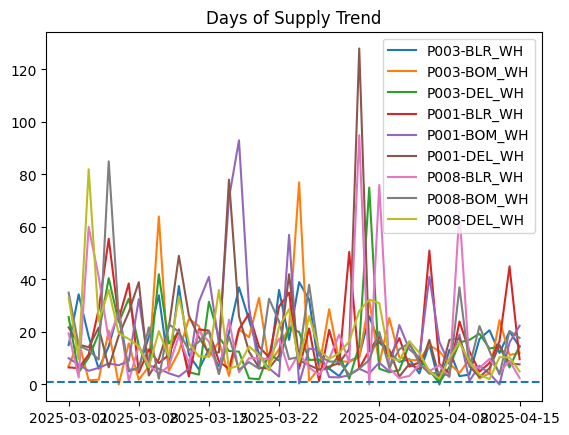

In [13]:
# ---------------- Days of Supply Trend ----------------
for sku in top_risk["sku"].unique()[:3]:
    subset = dos[dos["sku"] == sku]
    for wh in subset["warehouse"].unique():
        plt.plot(subset[subset["warehouse"]==wh]["date"],
                 subset[subset["warehouse"]==wh]["dos"],
                 label=f"{sku}-{wh}")

plt.axhline(1, linestyle="--")
plt.title("Days of Supply Trend")
plt.legend()
plt.show()


In [14]:
po = pd.read_csv("scm_po_receipts.csv", parse_dates=["eta_date"])
po.head()


,po_id,sku,warehouse,supplier,qty,eta_date,lead_time_days
0,PO0001,P001,BLR_WH,Supplier-C,151,2025-03-21,5
1,PO0002,P001,BLR_WH,Supplier-B,74,2025-03-07,5
2,PO0003,P001,BLR_WH,Supplier-A,104,2025-03-06,5
3,PO0004,P001,BLR_WH,Supplier-A,67,2025-03-29,5
4,PO0005,P001,BOM_WH,Supplier-C,65,2025-04-06,5


In [15]:
dos=dos.merge(po[["sku","eta_date","lead_time_days"]], on="sku",how="left")

In [16]:
dos["stockout_risk"] = (
    (dos["dos"] < dos["lead_time_days"]) &
    (dos["eta_date"] > dos["date"])
)


In [17]:
risk_table = (
    dos[dos["stockout_risk"]]
    .groupby(["sku","warehouse"])
    .agg(earliest_stockout=("date","min"),
         next_po_eta=("eta_date","first"),
         min_dos=("dos","min"))
    .reset_index()
)

risk_table.head()


,sku,warehouse,earliest_stockout,next_po_eta,min_dos
0,P001,BLR_WH,2025-03-08,2025-03-21,1.285714
1,P001,BOM_WH,2025-03-11,2025-03-21,0.000000
2,P001,DEL_WH,2025-03-09,2025-03-21,2.600000
3,P002,BLR_WH,2025-03-05,2025-03-15,0.500000
4,P002,BOM_WH,2025-03-02,2025-03-15,1.142857


In [18]:
def recommend(row):
    if row["min_dos"] < 1:
        return "Emergency transfer or air freight"
    elif row["min_dos"] < 3:
        return "Pull-in PO or rebalance"
    else:
        return "Monitor"

risk_table["recommendation"] = risk_table.apply(recommend, axis=1)
risk_table


,sku,warehouse,earliest_stockout,next_po_eta,min_dos,recommendation
0,P001,BLR_WH,2025-03-08,2025-03-21,1.285714,Pull-in PO or rebalance
1,P001,BOM_WH,2025-03-11,2025-03-21,0.000000,Emergency transfer or air freight
2,P001,DEL_WH,2025-03-09,2025-03-21,2.600000,Pull-in PO or rebalance
3,P002,BLR_WH,2025-03-05,2025-03-15,0.500000,Emergency transfer or air freight
4,P002,BOM_WH,2025-03-02,2025-03-15,1.142857,Pull-in PO or rebalance
5,P002,DEL_WH,2025-03-06,2025-03-15,1.200000,Pull-in PO or rebalance
6,P003,BLR_WH,2025-04-07,2025-04-16,0.000000,Emergency transfer or air freight
7,P003,BOM_WH,2025-03-03,2025-03-13,0.000000,Emergency transfer or air freight
8,P003,DEL_WH,2025-03-19,2025-03-27,0.625000,Emergency transfer or air freight
9,P004,BLR_WH,2025-03-01,2025-04-02,1.800000,Pull-in PO or rebalance


In [19]:
example = risk_table.iloc[0]
sku = example["sku"]
wh = example["warehouse"]


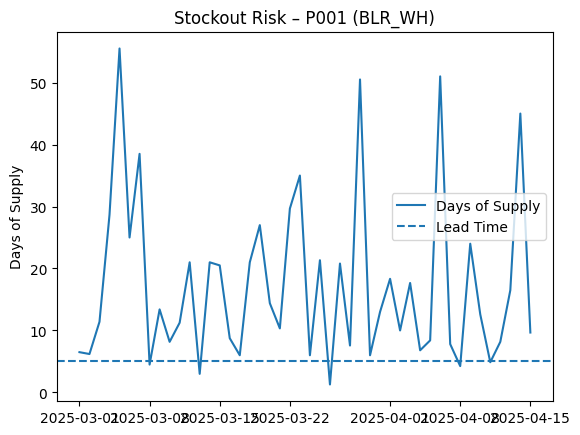

In [20]:
# ---------------- StockOut Risk ----------------
subset = dos[(dos["sku"]==sku) & (dos["warehouse"]==wh)]

plt.plot(subset["date"], subset["dos"], label="Days of Supply")
plt.axhline(subset["lead_time_days"].iloc[0], linestyle="--", label="Lead Time")
plt.title(f"Stockout Risk – {sku} ({wh})")
plt.ylabel("Days of Supply")
plt.legend()
plt.show()


In [21]:
summary = risk_table[[
    "sku",
    "warehouse",
    "earliest_stockout",
    "next_po_eta",
    "min_dos",
    "recommendation"
]].sort_values("earliest_stockout")

summary.head(10)


,sku,warehouse,earliest_stockout,next_po_eta,min_dos,recommendation
9,P004,BLR_WH,2025-03-01,2025-04-02,1.800000,Pull-in PO or rebalance
14,P007,DEL_WH,2025-03-01,2025-04-05,0.800000,Emergency transfer or air freight
4,P002,BOM_WH,2025-03-02,2025-03-15,1.142857,Pull-in PO or rebalance
15,P008,BLR_WH,2025-03-02,2025-03-07,0.000000,Emergency transfer or air freight
13,P007,BOM_WH,2025-03-02,2025-04-05,1.600000,Pull-in PO or rebalance
7,P003,BOM_WH,2025-03-03,2025-03-13,0.000000,Emergency transfer or air freight
10,P004,BOM_WH,2025-03-03,2025-04-02,1.666667,Pull-in PO or rebalance
12,P007,BLR_WH,2025-03-03,2025-04-05,0.333333,Emergency transfer or air freight
3,P002,BLR_WH,2025-03-05,2025-03-15,0.500000,Emergency transfer or air freight
5,P002,DEL_WH,2025-03-06,2025-03-15,1.200000,Pull-in PO or rebalance


In [22]:
# ---------------- OverAll KPI's ----------------
kpis = {
    "Overall Fill Rate": round(overall_fill, 2),
    "Average OTIF": round(orders["otif"].mean(), 2),
    "SKUs with Low DoS": dos["low_dos_flag"].sum(),
    "SKUs with Stockout Risk": risk_table.shape[0]
}

pd.DataFrame(kpis, index=["Value"])


,Overall Fill Rate,Average OTIF,SKUs with Low DoS,SKUs with Stockout Risk
Value,0.29,0.28,288,18


In [23]:
# ---------------- KPI CSV ----------------
sku_fill.to_csv("output_sku_fill_rate.csv")
carrier_otif.to_csv("output_carrier_otif.csv")
top_risk.to_csv("output_top_inventory_risk.csv")
risk_table.to_csv("output_stockout_risk.csv")


In [24]:
print("OVERALL FILL RATE:", round(overall_fill, 2))
print("AVERAGE OTIF:", round(orders["otif"].mean(), 2))
print("SKUs with LOW DoS:", dos["low_dos_flag"].sum())
print("SKU-Warehouse pairs with STOCKOUT RISK:", risk_table.shape[0])


OVERALL FILL RATE: 0.29
AVERAGE OTIF: 0.28
SKUs with LOW DoS: 288
SKU-Warehouse pairs with STOCKOUT RISK: 18


In [25]:
dashboard_kpis = pd.DataFrame({
    "Metric": [
        "Overall Fill Rate",
        "Average OTIF",
        "SKUs with Low DoS",
        "SKU-Warehouse Pairs at Stockout Risk"
    ],
    "Value": [
        round(overall_fill, 2),
        round(orders["otif"].mean(), 2),
        dos["low_dos_flag"].sum(),
        risk_table.shape[0]
    ]
})

dashboard_kpis


,Metric,Value
0,Overall Fill Rate,0.29
1,Average OTIF,0.28
2,SKUs with Low DoS,288.00
3,SKU-Warehouse Pairs at Stockout Risk,18.00


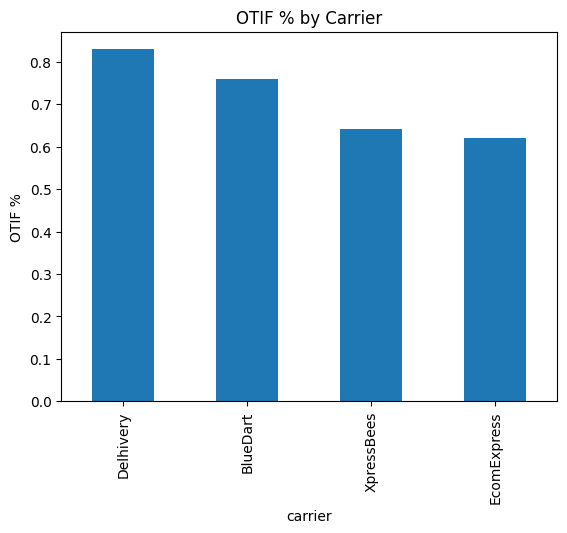

In [26]:
plt.figure()
carrier_otif.plot(kind="bar")
plt.title("OTIF % by Carrier")
plt.ylabel("OTIF %")
plt.show()


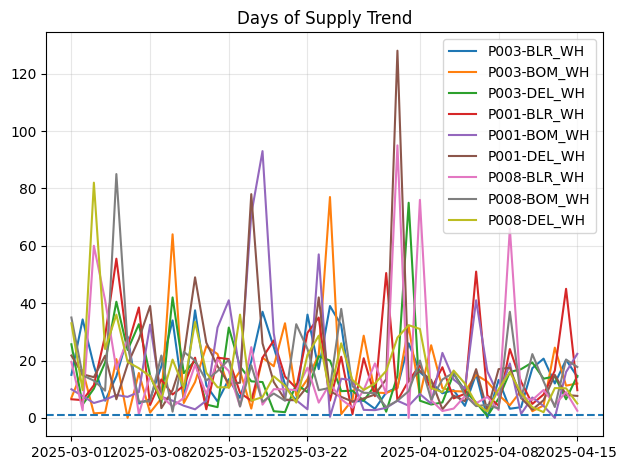

In [32]:
plt.figure()
for sku in top_risk["sku"].unique()[:3]:
    subset = dos[dos["sku"] == sku]
    for wh in subset["warehouse"].unique():
        plt.plot(subset[subset["warehouse"]==wh]["date"],
                 subset[subset["warehouse"]==wh]["dos"],
                 label=f"{sku}-{wh}")

plt.axhline(1, linestyle="--")
plt.title("Days of Supply Trend")
plt.legend(loc="upper right")   # Move legend to clear space
plt.grid(True, alpha=0.3)       # Light grid for readability
plt.tight_layout()     
plt.legend()
plt.show()


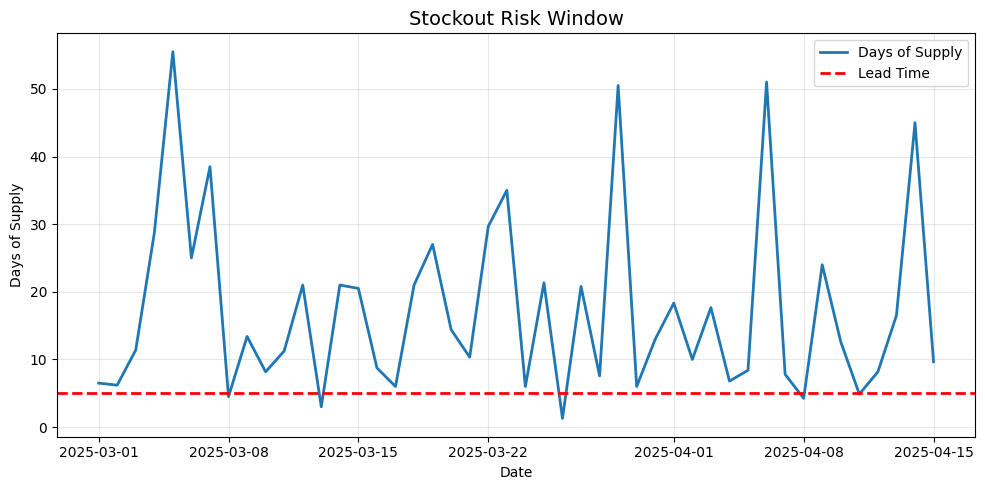

In [31]:
example = dos[(dos["sku"]==risk_table.iloc[0]["sku"]) &
              (dos["warehouse"]==risk_table.iloc[0]["warehouse"])]

plt.figure(figsize=(10,5))  # Wider figure

plt.plot(example["date"], example["dos"], linewidth=2, label="Days of Supply")

plt.axhline(example["lead_time_days"].iloc[0],
            linestyle="--",
            linewidth=2,
            color="red",
            label="Lead Time")

plt.title("Stockout Risk Window", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Days of Supply")

plt.legend(loc="upper right")   # Move legend to clear space
plt.grid(True, alpha=0.3)       # Light grid for readability
plt.tight_layout()              # Prevent label overlap

plt.savefig(r"D:\SCM_Dashboard\stockOut.png")
plt.show()


In [ ]:
risk_table[[
    "sku",
    "warehouse",
    "earliest_stockout",
    "next_po_eta",
    "min_dos",
    "recommendation"
]].sort_values("earliest_stockout").head(10)


,sku,warehouse,earliest_stockout,next_po_eta,min_dos,recommendation
9,P004,BLR_WH,2025-03-01,2025-04-02,1.800000,Pull-in PO or rebalance
14,P007,DEL_WH,2025-03-01,2025-04-05,0.800000,Emergency transfer or air freight
4,P002,BOM_WH,2025-03-02,2025-03-15,1.142857,Pull-in PO or rebalance
15,P008,BLR_WH,2025-03-02,2025-03-07,0.000000,Emergency transfer or air freight
13,P007,BOM_WH,2025-03-02,2025-04-05,1.600000,Pull-in PO or rebalance
7,P003,BOM_WH,2025-03-03,2025-03-13,0.000000,Emergency transfer or air freight
10,P004,BOM_WH,2025-03-03,2025-04-02,1.666667,Pull-in PO or rebalance
12,P007,BLR_WH,2025-03-03,2025-04-05,0.333333,Emergency transfer or air freight
3,P002,BLR_WH,2025-03-05,2025-03-15,0.500000,Emergency transfer or air freight
5,P002,DEL_WH,2025-03-06,2025-03-15,1.200000,Pull-in PO or rebalance
